# Task B- Ordinary Least Squares Regression

 ## Loading the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import re


ModuleNotFoundError: No module named 'pandas'

In [ ]:
sns.set_theme(style="whitegrid")

# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

df = pd.read_json(
    "data/chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [2]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "data/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "data/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [3]:
# Extracting the prompt
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

#### Establishing a "winner" column to display the outcome of the competition between model a and model b.

In [4]:
df['winner_name'] = np.where(
    df['winner'] == 'model_a', df['model_a'],
    np.where(
        df['winner'] == 'model_b', df['model_b'],
        np.where(
            df['winner'] == 'tie(bothbad)', 'tie(bothbad)',
            df['model_a'] + ' & ' + df['model_b']))
)

In [5]:
#create one-hot encodings for the winning chatbot model
#this will attribute a value of 1 to the model if that model wins or there is a tie(bothgood) otherwise it gives it a 0
#there were around 20 chatbots so i think it might be too chaotic to do this for individual chatbots
df['one_hot_a'] = np.where(
    (df['winner'] == 'model_a') | (df['winner'] == 'tie'), 1, 0)

df['one_hot_b'] = np.where(
    (df['winner'] == 'model_b') | (df['winner'] == 'tie'), 1, 0)


In [6]:
#add columns to separate responses from the conversation (we already did this for the prompt)
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

In [7]:
#create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() #use this if you want to know statistics about prompt and response lengths

df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


In [8]:
#assigns a numerical value to the name of the winning chatbot
#this might be helpful for one hot encodings - if not we can take it out later

#create function to assign numerical values to unique names
def unique_name_ids(names):
    # Create an empty list to store unique names
    unique_names = set()

    # Split names at the & and strip whitespace
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        unique_names.update(parts)  # Add unique parts to the set

    # map names to unique id numbers
    name_to_id = {name: idx for idx, name in enumerate(unique_names)}

    # store list of ids and names
    ids = []
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        name_ids = [name_to_id[part] for part in parts]
        ids.append(name_ids)

    return ids

# Apply the function to create a new column
df['winner_name_id'] = unique_name_ids(df['winner_name'])

### Engineering feature of dot product similarity between embeddings

In [9]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]


#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [10]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [11]:
topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [12]:
#this will merge the mean value of the hardness scores and the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

#### Removing question ids that produce null values and storing the final dataset into filtered_df

In [13]:
# To Do: fetch code where we identified these question IDs @caroline
# This will remove question ids that produced null values for topic_and_hardness
filtered_df = merged_df[
    ~merged_df['question_id'].isin([
        'e6d45ead33114cca8ee3cfa028517eff',
        'addaa796ee094f029f8014ea1468df8a',
        'd37eb99864fa41ecab49026abdddb53e',
        '6da02001e74041d0947982fb4d05db9e',
        'd93e36df73e84aa2ade15d4a038c098f',
        '50b63f92bc5948218e1555d1eae17797',
        '8277b16d9a0845d694a33c04f446926c',
        'd56d698d4c1c495682a366f2a78fcb77',
        '86c7abedb5f84b7ea752cc98d324d387',
        '974569d7b9c74ca591f1922bf3722266',
        'ba3cfbae941946c6a41ea725b46f3aa7',
        '283be8724d674cb6a74da59d0c12ea16',
        'fbd400babd914eb1ad6202b4400d6beb',
        '087b90bf76ed4c409b7c7bd5d6b0d6c5',
        'f9ad250d0194489b8b9f12d31386aab1',
        '7e371a23981847c7b19bc61195f11eda',
        'f55b273603754c0d92f5139351ca0d02',
        '255e1466eaf14cc2ba93040776c0c440',
        '6979b646271e46f4a329a5e6acaeed38',
        'ed7fa335d5524295b1dd79452778d26c',
        'f794c699e4964b11a1373976be5b0944',
        'c92bcab701cc46649368fc121b84ccc1',
        'a632607132cf4908883fd262102714c9',
        'a0857d64b4954ea6bd75c2406c3dd32c',
        'e4a1fc8a9462475d95022914cb9f5b03',
        'c7aa752f61dc46d093dc86713686f6f3'
    ])
]


#### Calculating the ELO ratings per model:

In [14]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)




ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.688016
10                    gpt-4  1250.726993
11                claude-v1  1234.758964
19              guanaco-33b  1124.567221
9             gpt-3.5-turbo  1110.799361
3                vicuna-13b  1109.473792
14                   palm-2  1074.086047
2                 koala-13b  1069.641717
16                vicuna-7b  1050.621375
17             wizardlm-13b   997.391029
13              mpt-7b-chat   969.416715
12         RWKV-4-Raven-14B   937.085978
5                alpaca-13b   928.131634
18       gpt4all-13b-snoozy   926.279119
0                chatglm-6b   889.066656
1          oasst-pythia-12b   884.891087
4   stablelm-tuned-alpha-7b   839.718473
8            fastchat-t5-3b   827.172397
6                 llama-13b   773.750292
7              dolly-v2-12b   709.733134


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in task A (predicting whether model a or model b will win)

In [15]:
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

# Display the first few rows to verify the new column
filtered_df.columns

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/403063721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(


Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'winner_name',
       'one_hot_a', 'one_hot_b', 'model_a_response', 'model_b_response',
       'prompt_length', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb'],
      dtype='object')

## Topics feature

In [16]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'fact\w*': 'topic_fact',
    r'creativ\w*': 'topic_creative',
    r'problem[ -]?solving': 'topic_problem_solving'
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

# Check the updated DataFrame
filtered_df.head()

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/4182628651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/4182628651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,winner_name_id,similarity_prompt_response_a,similarity_prompt_response_b,hardness_score,topic_modeling_3,elo_modela_minus_modelb,topic_math,topic_fact,topic_creative,topic_problem_solving
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,[2],1.0,0.853198,8.666667,"Comparison, Technology",-180.575061,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,"[5, 10]",1.0,0.540338,8.333333,"Reasoning, Emotional",-43.240547,0,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,[5],1.0,0.851614,3.333333,Photography comparison,184.750630,0,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,[5],1.0,0.918109,8.000000,Chatbot Arena,224.582706,0,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,[1],1.0,0.352887,2.000000,Time-based Inquiry,39.832075,0,0,0,0


## Auxiliary verbs feature

In [ ]:
# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/3573132758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/3573132758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,model_b_response_contains_can,model_b_response_contains_could,model_b_response_contains_may,model_b_response_contains_might,model_b_response_contains_shall,model_b_response_contains_should,model_b_response_contains_will,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,1,0,0,0,0,0,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,0,1,0,0,0,0,0,1,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,0,0,1,0,0,0,1,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,1,1,0,0,0,1,1,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Question words feature

# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_9751/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
## Feature engineering: interaction terms

# Will the combined length of both of the models' responses have an impact on hardness score?
filtered_df.loc[:, 'length_interaction'] = (filtered_df['response_a_length'] * filtered_df['response_b_length'])

# Interaction between response lengths and sentiment polarity
# Thought process: a long positive response may be deemed a low hardness score and a long negative response may be deemed a high hardness score
filtered_df['response_a_length_polarity'] = (filtered_df['response_a_length'] * filtered_df['model_a_response_polarity'])
filtered_df['response_b_length_polarity'] = (filtered_df['response_b_length'] * filtered_df['model_b_response_polarity'])

# Will this interaction between ELO ratings provide insight into whether difference in the skill level between models contributes to hardness scores?
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']], axis=1)

In [ ]:
def extract_textblob_features(df, text_column):
    """ 
    To extract sentiment and linguistic features utilizing TextBlob

    Parameters:
        df: Input Dataframe
        text_column: Name of column with text data

    Returns:
        df: Updated Dataframe with the extracted features as new columns
    """
    polarity = []
    subjectivity = []
    noun_count = []
    verb_count = []
    adj_count = []

    for text in df[text_column]:
        # Create TextBlob object
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
        noun_count.append(len([word for word, pos in blob.tags if pos.startswith('NN')]))  # Count nouns
        verb_count.append(len([word for word, pos in blob.tags if pos.startswith('VB')]))  # Count verbs
        adj_count.append(len([word for word, pos in blob.tags if pos.startswith('JJ')]))  # Count adjectives

    # Add extracted features to the DataFrame
    df[f"{text_column}_polarity"] = polarity
    df[f"{text_column}_subjectivity"] = subjectivity
    df[f"{text_column}_noun_count"] = noun_count
    df[f"{text_column}_verb_count"] = verb_count
    df[f"{text_column}_adj_count"] = adj_count

    return df

# Apply to prompts and responses
filtered_df = extract_textblob_features(filtered_df, 'prompt')
filtered_df = extract_textblob_features(filtered_df, 'model_a_response')
filtered_df = extract_textblob_features(filtered_df, 'model_b_response')

# Generate additional word counts
filtered_df['prompt_word_count'] = filtered_df['prompt'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_a_word_count'] = filtered_df['model_a_response'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_b_word_count'] = filtered_df['model_b_response'].apply(lambda x: len(TextBlob(x).words))


In [30]:
# Interaction between polarity and subjectivity
filtered_df['prompt_polarity_subjectivity'] = (
    filtered_df['prompt_polarity'] * filtered_df['prompt_subjectivity']
)

# Interaction between response lengths and sentiment polarity
filtered_df['response_a_length_polarity'] = (
    filtered_df['response_a_length'] * filtered_df['model_a_response_polarity']
)
filtered_df['response_b_length_polarity'] = (
    filtered_df['response_b_length'] * filtered_df['model_b_response_polarity']
)

# Difference between polarity and subjectivity of responses
filtered_df['polarity_difference'] = (
    filtered_df['model_a_response_polarity'] - filtered_df['model_b_response_polarity']
)
filtered_df['subjectivity_difference'] = (
    filtered_df['model_a_response_subjectivity'] - filtered_df['model_b_response_subjectivity']
)


### Set Features

In [ ]:
# The selected features
selected_features = ['prompt_length',
    'length_interaction', 'elo_modela_minus_modelb',
    'prompt_noun_count', 'prompt_verb_count', 
    'response_a_length_polarity', 'response_b_length_polarity',
    'model_a_response_noun_count', 'model_a_response_verb_count',
    'model_b_response_noun_count', 'model_b_response_verb_count', 'topic_math', 'topic_creative']

### Model

In [ ]:
# Ensure no NaN or inf values in the target variable
y = filtered_df['hardness_score']
if y.isnull().sum() > 0 or np.isinf(y).sum() > 0:
    print(f"NaN values in 'hardness_score': {y.isnull().sum()}")
    print(f"Inf values in 'hardness_score': {np.isinf(y).sum()}")
    y = y.dropna()
    y = y[~np.isinf(y)]

# Filter X to include only the selected features
X = filtered_df[selected_features]

# Remove rows from X where y has been dropped
X = X.loc[y.index]

# Ensure no NaN or inf values in X
X = X.dropna()
X = X[~np.isinf(X).any(axis=1)]

# Realign indices for X and y
X, y = X.align(y, axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Check for non-finite values in the target
print("Number of NaN values in y_train:", y_train.isna().sum())
print("Number of NaN values in y_test:", y_test.isna().sum())

print("Number of inf values in y_train:", np.isinf(y_train).sum())
print("Number of inf values in y_test:", np.isinf(y_test).sum())

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target to integers for classification
y_train = y_train.round().astype(int)
y_test = y_test.round().astype(int)

# Add a constant term for the intercept
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Summary of the model
print(ols_model.summary())

# Make predictions
y_pred_ols = ols_model.predict(X_test_ols)
y_pred_ols_rounded = np.clip(np.round(y_pred_ols), 1, 10)  # Ensure predictions are between 1 and 10

# Evaluate the model
mse_ols = mean_squared_error(y_test, y_pred_ols_rounded)
print(f"\nOLS Model MSE: {mse_ols:.2f}")

NaN values in 'hardness_score': 33
Inf values in 'hardness_score': 0
Shape of X_train: (20178, 13)
Shape of y_train: (20178,)
Number of NaN values in y_train: 0
Number of NaN values in y_test: 0
Number of inf values in y_train: 0
Number of inf values in y_test: 0
                            OLS Regression Results                            
Dep. Variable:         hardness_score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     269.2
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:41:08   Log-Likelihood:                -38268.
No. Observations:               20178   AIC:                         7.656e+04
Df Residuals:                   20164   BIC:                         7.668e+04
Df Model:                          13                                         
Covariance Type:         

### To separate into MSE for training, testing and validation- as suggested from milestone 5

In [ ]:
# Prepare the data
X = filtered_df[selected_features]
y = filtered_df['hardness_score']

# Drop rows with NaN in either X or y
data = pd.concat([X, y], axis=1).dropna()
X = data[selected_features]
y = data['hardness_score']

# Add a constant for OLS
X = sm.add_constant(X)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
training_mse = []
validation_mse = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"Processing Fold {fold}...")
    
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure no NaN or inf values remain in training and testing sets
    assert not X_train.isnull().values.any(), "NaN values in X_train"
    assert not y_train.isnull().values.any(), "NaN values in y_train"
    assert not X_test.isnull().values.any(), "NaN values in X_test"
    assert not y_test.isnull().values.any(), "NaN values in y_test"
    assert not np.isinf(X_train).values.any(), "Inf values in X_train"
    assert not np.isinf(y_train).values.any(), "Inf values in y_train"
    assert not np.isinf(X_test).values.any(), "Inf values in X_test"
    assert not np.isinf(y_test).values.any(), "Inf values in y_test"
    
    # Fit the OLS model
    ols_model = sm.OLS(y_train, X_train).fit()
    
    # Predictions for training and testing sets
    y_train_pred = ols_model.predict(X_train)
    y_test_pred = ols_model.predict(X_test)
    
    # Calculate MSE for training and testing sets
    training_mse.append(mean_squared_error(y_train, y_train_pred))
    validation_mse.append(mean_squared_error(y_test, y_test_pred))

# Calculate average MSE across folds
avg_training_mse = np.mean(training_mse)
avg_validation_mse = np.mean(validation_mse)

# Fit OLS model on the entire dataset for testing
ols_model_full = sm.OLS(y, X).fit()
y_pred_full = ols_model_full.predict(X)

# Calculate full test MSE
test_mse = mean_squared_error(y, y_pred_full)

# Print results
print("\nOLS Model MSE:")
print(f"Average Training MSE: {avg_training_mse:.2f}")
print(f"Average Validation MSE: {avg_validation_mse:.2f}")
print(f"Full Test MSE: {test_mse:.2f}")


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

OLS Model MSE:
Average Training MSE: 2.51
Average Validation MSE: 2.51
Full Test MSE: 2.51


### Visualizations

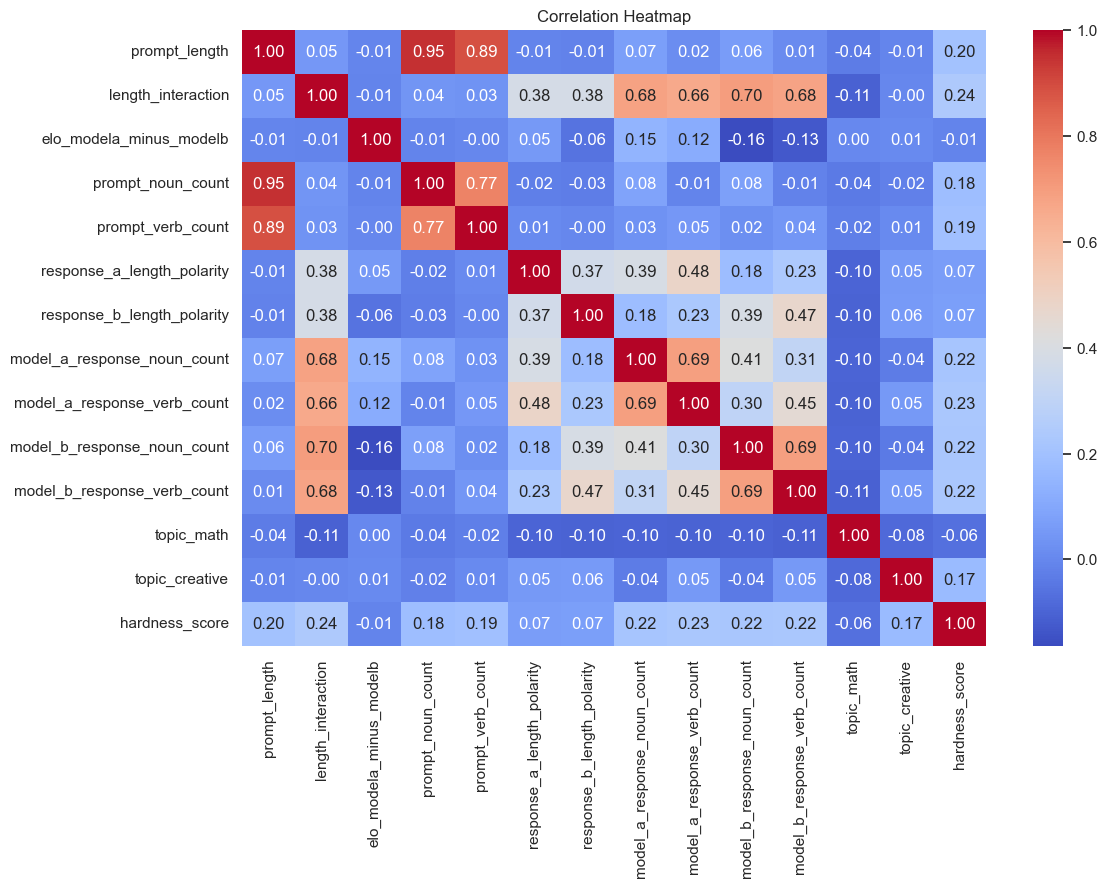

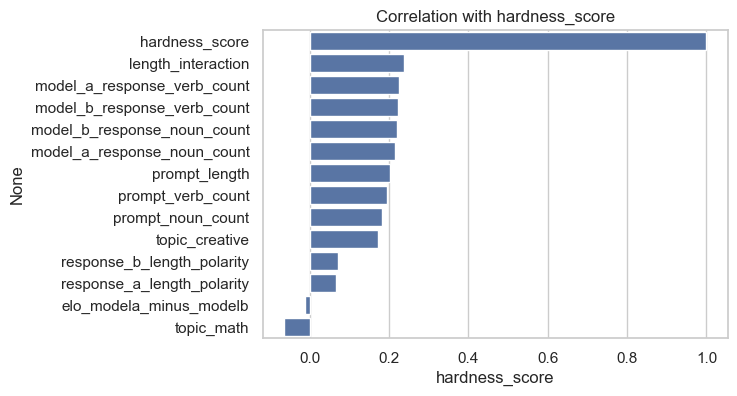

In [ ]:
# Correlation Heatmap
def plot_correlation_heatmap(data, target_column):
    """ 
    Displays a heatmap of feature correlations
    """
    corr = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    
    # Correlation with target variable
    plt.figure(figsize=(6, 4))
    target_corr = corr[target_column].sort_values(ascending=False)
    sns.barplot(x=target_corr, y=target_corr.index)
    plt.title(f"Correlation with {target_column}")
    plt.show()

# Correlation heatmap (pass your filtered_df and target column name)
plot_correlation_heatmap(filtered_df[selected_features + ['hardness_score']], 'hardness_score')


In [2]:
# Residual Analysis Boxplot
sns.boxplot(x=pd.cut(y_test, bins=[0, 3, 6, 9], labels=["Low", "Mid", "High"]), y=y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Analysis")

NameError: name 'sns' is not defined

In [ ]:
def plot_hardness_score_distributions_ols(true_values, predicted_values):
    """
    Compares the distributions of true and predicted hardness scores for the OLS model.
    Useful for identifying any shifts or inconsistencies in prediction.

    Parameters:
    - true_values: Array or list of true hardness scores.
    - predicted_values: Array or list of predicted hardness scores from the OLS model.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(true_values, kde=True, bins=30, color='blue', label='True', alpha=0.5)
    sns.histplot(predicted_values, kde=True, bins=30, color='green', label='Predicted', alpha=0.5)
    plt.title('Distribution of True vs Predicted Hardness Scores (OLS)')
    plt.xlabel('Hardness Scores')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Ensure you have the OLS predictions:
y_pred_ols = ols_model.predict(X_test)  # Replace `X_test` with your test dataset.
y_true_ols = y_test  # Replace `y_test` with the actual true values for the test set.

# Call the function with true and predicted values:
plot_hardness_score_distributions_ols(y_true_ols, y_pred_ols)
